In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [9]:
# Define the generator model
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.model(x)

# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

# Define the GAN model
class GAN(nn.Module):
    def __init__(self, input_size_g, output_size_g, input_size_d, hidden_size_d=128):
        super(GAN, self).__init__()
        self.generator = Generator(input_size_g, output_size_g)
        self.discriminator = Discriminator(input_size_d, hidden_size_d)

    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x
    
# Custom dataset class
class OdorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data.iloc[idx][["xsrc", "ysrc", "odor", "corrected_u", "corrected_v"]]
        return torch.tensor(sample.values, dtype=torch.float32)

In [46]:
# Load and preprocess data
dir = '~/DataAnalysis/data/Sprints/HighRes/'
data = pd.read_hdf(dir+'Windy/WindyMASigned.h5') # Replace with your data file

In [47]:
new_data=data[:30000]

In [52]:
dataset = OdorDataset(new_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize GAN, optimizer, and loss function
input_size_g = 4  # xsrc, ysrc, wind_velocity_U, and wind_velocity_V
output_size_g = 1  # New odor measurement
input_size_d = 5  # xsrc, ysrc, odor, wind_velocity_U, and wind_velocity_V

gan = GAN(input_size_g, output_size_g, input_size_d)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gan.to(device)

optimizer = optim.Adam(gan.parameters(), lr=0.001)
criterion = nn.BCELoss()




In [54]:
num_epochs = 30
for epoch in range(num_epochs):
    for i, real_data in enumerate(dataloader):
        real_data = real_data.to(device)
        input_gen = real_data[:, [0, 1, 3, 4]]

        generated_odor = gan.generator(input_gen)
        fake_data = torch.cat((input_gen[:, :2], generated_odor, input_gen[:, 2:]), dim=1)

        real_labels = torch.ones(real_data.size(0), 1).to(device)
        fake_labels = torch.zeros(fake_data.size(0), 1).to(device)

        optimizer.zero_grad()

        real_outputs = gan.discriminator(real_data)
        real_loss = criterion(real_outputs, real_labels)

        fake_outputs = gan.discriminator(fake_data.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer.step()

        optimizer.zero_grad()

        fake_outputs = gan.discriminator(fake_data)
        g_loss = criterion(fake_outputs, real_labels)

        g_loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')
        fixed_noise = torch.randn(64, input_size_g).to(device)
        generated_samples = gan.generator(fixed_noise).detach().cpu().numpy()
        print(generated_samples)

Epoch [10/30], d_loss: 1.2808408737182617, g_loss: 0.47932636737823486
Epoch [20/30], d_loss: 1.1237965822219849, g_loss: 0.5511912703514099
Epoch [30/30], d_loss: 0.9937782883644104, g_loss: 0.574953556060791


In [42]:
t_data=data[405000:410000]

In [43]:
test_data = torch.tensor([
    t_data.xsrc.values,
    t_data.ysrc.values,
    t_data.corrected_u.values,
    t_data.corrected_v.values
], dtype=torch.float32).T  # Transpose to have the correct shape

generated_odor = gan.generator(test_data)
# print(generated_odor)


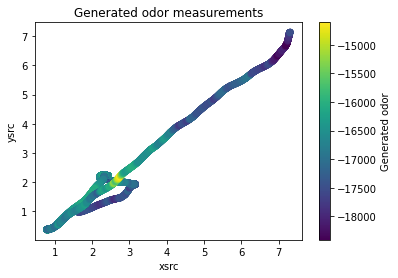

In [44]:
# Convert generated odor to NumPy array
generated_odor_np = generated_odor.detach().numpy()

# Get xsrc and ysrc values
xsrc_values = t_data.xsrc.values
ysrc_values = t_data.ysrc.values

# Create a scatter plot
plt.scatter(xsrc_values, ysrc_values, c=generated_odor_np, cmap='viridis', marker='o')
plt.colorbar(label='Generated odor')
plt.xlabel('xsrc')
plt.ylabel('ysrc')
plt.title('Generated odor measurements')
plt.show()

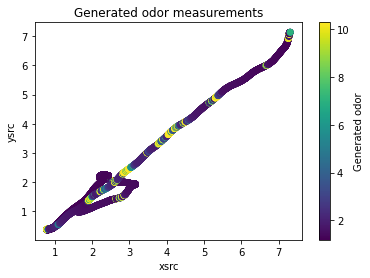

In [45]:
# Create a scatter plot
plt.scatter(xsrc_values, ysrc_values, c=t_data.odor, cmap='viridis', marker='o')
plt.colorbar(label='Generated odor')
plt.xlabel('xsrc')
plt.ylabel('ysrc')
plt.title('Generated odor measurements')
plt.show()